# Разработка A/B-тестирования и анализ результатов
Для анализа предоставлены данные развлекательного приложения с функцией «бесконечной» ленты. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.
Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. 

**Цель проекта:** рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Данные представлены в 3 таблицах:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Загружаем данные
sessions_history = pd.read_csv('sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [3]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


#### 1.2. Знакомство с данными



In [33]:
# Находим пользователя с наибольшим кол-вом сессий
max_sessions_user = sessions_history['user_id'].value_counts().idxmax()
max_sessions_user

'6A73CB5566BB494D'

In [34]:
# Выводим данные для этого пользователя
sessions_history[sessions_history['user_id'] == max_sessions_user]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций

In [7]:
# Группируем данные по дате и считаем кол-во уник. и зарегистрированных польз-лей
sh_agg = sessions_history.groupby('session_date').agg({'user_id': 'nunique', 
                                                       'registration_flag': 'sum'}).reset_index()
sh_agg.head()

,session_date,user_id,registration_flag
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


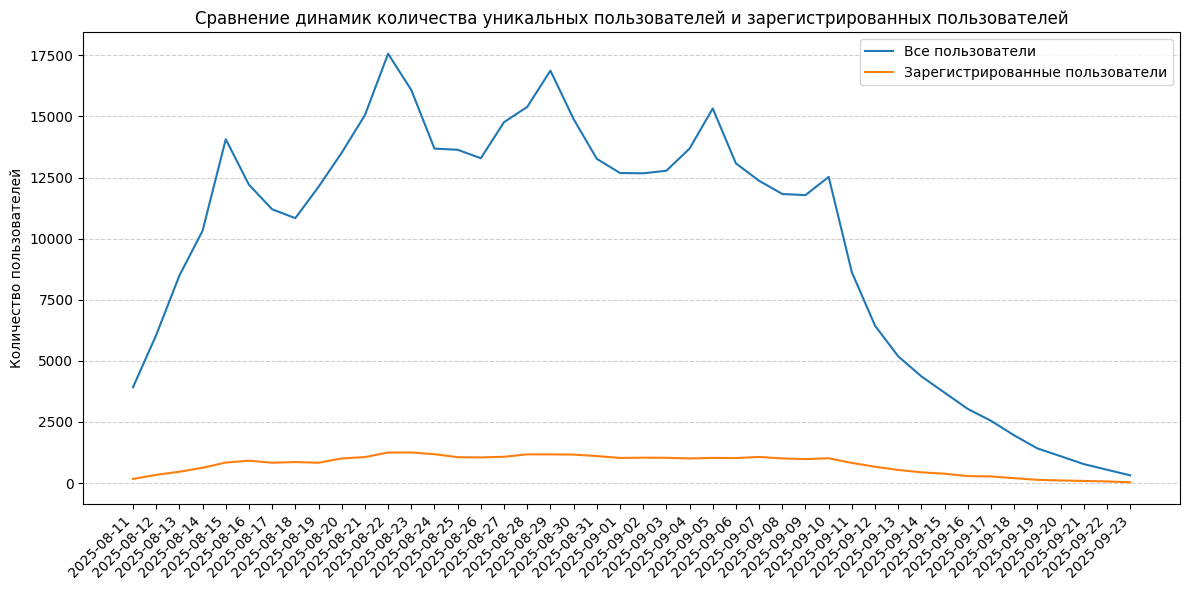

In [8]:
# График общего числа пользователей и зарегистрированных
plt.figure(figsize = (12, 6))

x = sh_agg['session_date']
y_users = sh_agg['user_id']
y_registrate = sh_agg['registration_flag']
plt.plot(x, y_users, label = 'Все пользователи')
plt.plot(x, y_registrate, label = 'Зарегистрированные пользователи')

plt.title('Сравнение динамик количества уникальных пользователей и зарегистрированных пользователей')
plt.xlabel('')
plt.ylabel('Количество пользователей')
plt.xticks(rotation = 45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)

plt.show()

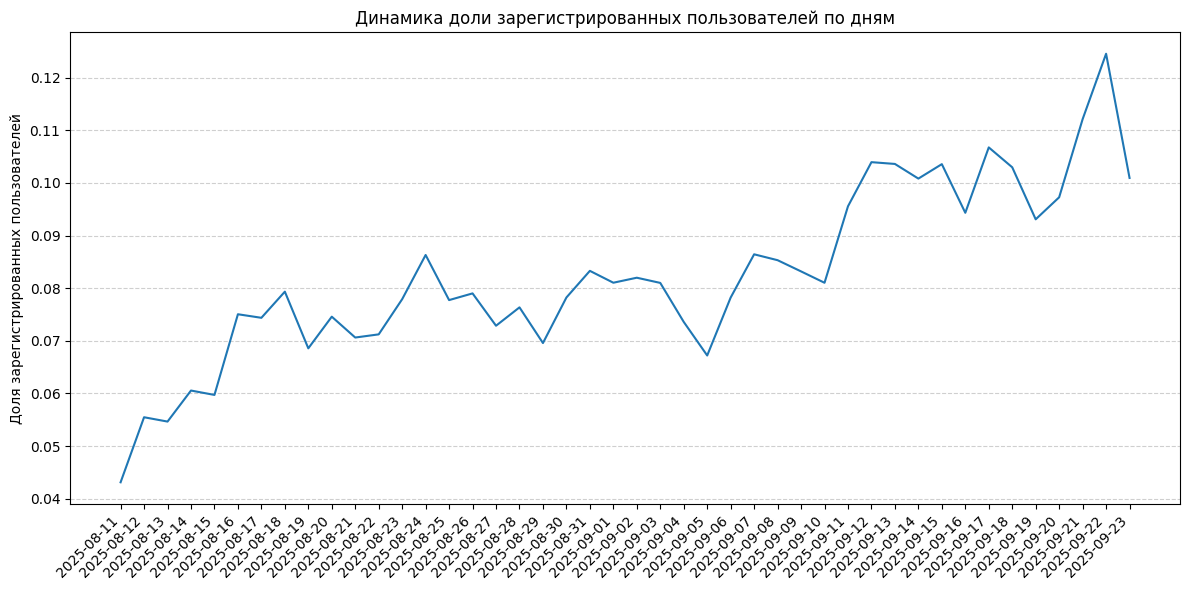

In [9]:
# Расчёт доли зарегистрированных пользователей
y_share = y_registrate / y_users

# График доли зарегистрированных пользователей
plt.figure(figsize = (12, 6))

plt.plot(x, y_share)

plt.title('Динамика доли зарегистрированных пользователей по дням')
plt.xlabel('')
plt.ylabel('Доля зарегистрированных пользователей')
plt.xticks(rotation = 45, ha='right')
plt.tight_layout()
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)

plt.show()

Основываясь на графиках можно сделать вывод, что общее количество пользователей демонстрирует стабильный рост вначале и постепенный спад в последние две недели. На графике также заметна чёткая недельная сезонность: каждый раз по пятницам фиксируется резкий рост активности пользователей. Это типично для развлекательных приложений, так как по окончании рабочей недели пользователи чаще возвращаются к контенту для отдыха и развлечения.

Существенных аномалий в динамике доли зарегистрированных пользователей не наблюдается — рост происходит равномерно, что свидетельствует о стабильном привлечении и конверсии пользователей в рассматриваемый период.

#### 1.4. Анализ числа просмотренных страниц


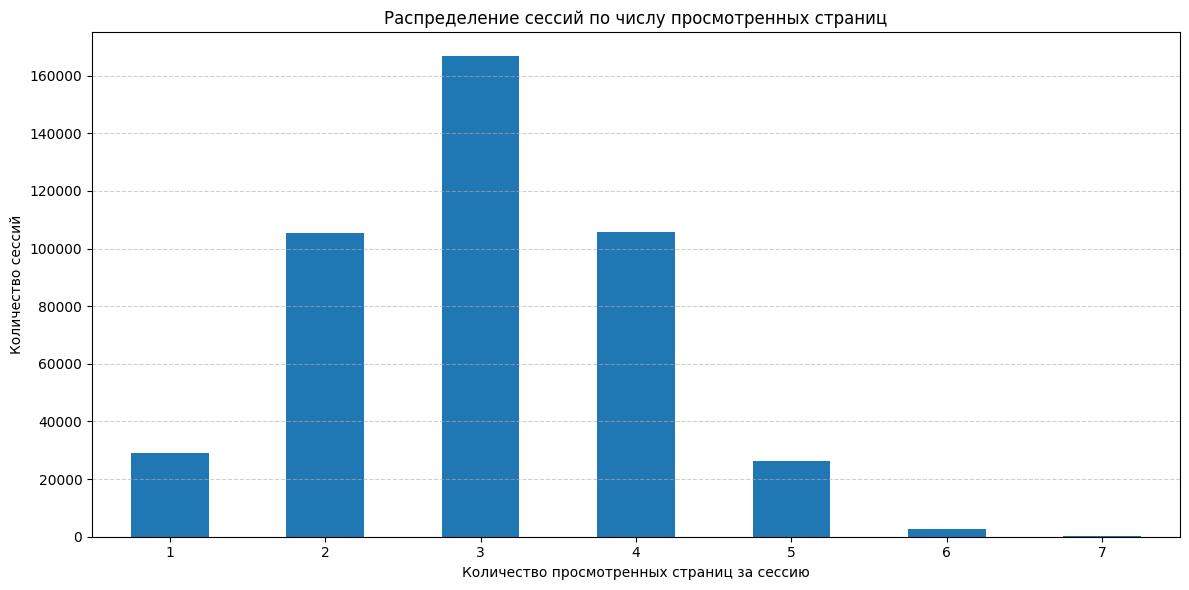

In [10]:
# Считаем кол-во сессий для каждого значения кол-ва просмотренных страниц
page_views_count = sessions_history.groupby('page_counter')['session_id'].count()

# Построение столбчатой диаграммы
plt.figure(figsize = (12, 6))

page_views_count.plot(kind = 'bar',
                      rot = 0)

plt.title('Распределение сессий по числу просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xlabel('Количество просмотренных страниц за сессию')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.tight_layout()

plt.show()

На графике видно, что большинство сессий заканчиваются после просмотра 2–4 страниц. При этом количество сессий резко уменьшается с увеличением числа просмотренных страниц. Это нормальное распределение для приложений с бесконечной лентой контента, когда основная масса пользователей вовлекается лишь частично.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц


In [11]:
# Добавляем колонку good_session: 1 - если 4 и более страниц, иначе 0
sessions_history['good_session'] = (sessions_history['page_counter']>=4).astype(int)
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [12]:
# Группируем данные по дням и считаем среднюю долю успешных сессий
daily_good_sessions = sessions_history.groupby('session_date')['good_session'].mean().reset_index()
daily_good_sessions.head()

,session_date,good_session
0,2025-08-11,0.312835
1,2025-08-12,0.302015
2,2025-08-13,0.306750
3,2025-08-14,0.316055
4,2025-08-15,0.304941


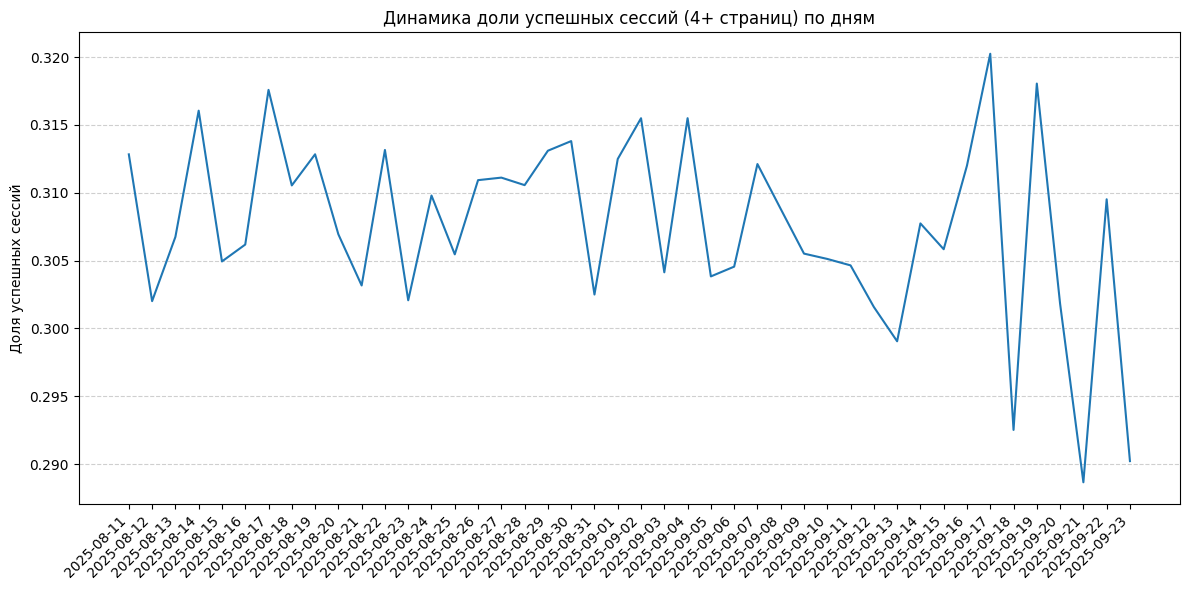

In [13]:
# Построение графика
plt.figure(figsize = (12,6))

plt.plot(daily_good_sessions['session_date'],
         daily_good_sessions['good_session'])

plt.title('Динамика доли успешных сессий (4+ страниц) по дням')
plt.ylabel('Доля успешных сессий')
plt.xlabel('')
plt.xticks(rotation = 45, ha = 'right')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.6)
plt.tight_layout()
plt.show()

Доля пользователей, просмотревших 4 и более страниц за сессию, остаётся стабильной на протяжении всего наблюдаемого периода. Это говорит о том, что уровень вовлечённости пользователей в контент приложения не претерпевал существенных изменений, а поведение аудитории оставалось постоянным. 

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста.

#### 2.1. Расчёт размера выборки

Параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. 

In [14]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста


In [15]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users:.0f} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей


Для расчёта процентной разницы воспользуйтемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [16]:
# Загружаем данные за первый день проведения ab теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [17]:
# Группируем данные по тестовой группе и считаем кол-во уник.пользователей
group_users = sessions_test_part.groupby('test_group')['user_id'].nunique().reset_index()
group_users 

,test_group,user_id
0,A,1477
1,B,1466


In [18]:
# Разбиваем на A и B
group_a = group_users[group_users['test_group'] == 'A']['user_id'].values[0]
group_b = group_users[group_users['test_group'] == 'B']['user_id'].values[0]
# Расчёт процентной разницы
P = 100 * abs(group_a - group_b)/group_a

print(f"Количество пользователей в группе A: {group_a}")
print(f"Количество пользователей в группе B: {group_b}")
print(f"Процентная разница между группами: {P:.2f}%")

Количество пользователей в группе A: 1477
Количество пользователей в группе B: 1466
Процентная разница между группами: 0.74%


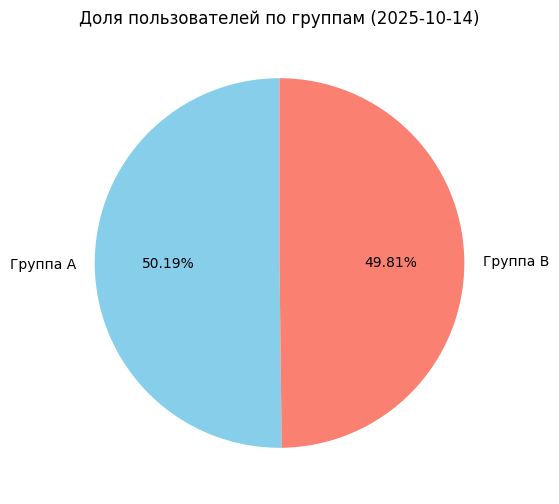

In [19]:
# Строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie([group_a, group_b],
        labels=['Группа A', 'Группа B'],
        autopct='%1.2f%%',
        colors=['skyblue', 'salmon'],
        startangle=90)
plt.title('Доля пользователей по группам (2025-10-14)')
plt.show()

Доли пользователей по группам распределены равномерно

#### 3.2. Проверка пересечений пользователей


In [38]:
# Находим id уникальных пользователей для каждой группы
groupA = set(sessions_test_part[sessions_test_part['test_group']=='A']['user_id']) 
groupB = set(sessions_test_part[sessions_test_part['test_group']=='B']['user_id'])
# Находим пересечение пользователей из двух групп
intersection = list(groupA & groupB)
intersection

[]

Пересечений пользователей нет

#### 3.3. Равномерность разделения пользователей по устройствам

In [45]:
# Группировка и подсчёт уникальных пользователей по устройству для групп A и B
device_distribution = sessions_test_part.groupby(['test_group', 'device'])['user_id'].nunique().reset_index()
# Преобразуем для удобства построения графика
device_pivot = device_distribution.pivot(index='device', columns='test_group', values='user_id')
device_pivot

test_group,A,B
device,,
Android,656,668
Mac,156,148
PC,369,381
iPhone,296,269


<Figure size 1200x600 with 0 Axes>

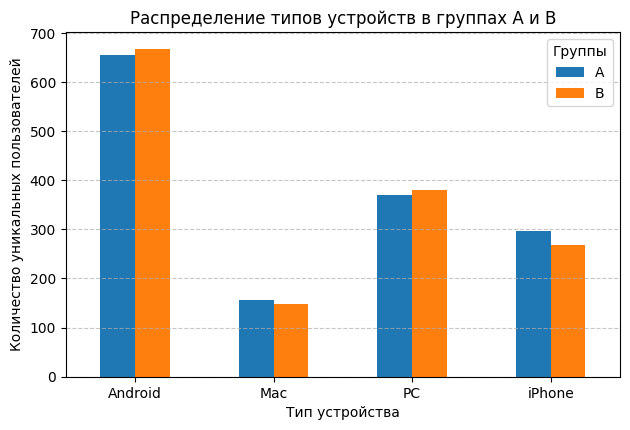

In [52]:
# Строим столбчатую диаграмму
plt.figure(figsize = (12, 6))
device_pivot.plot(kind = 'bar')

# Оформляем график
plt.title('Распределение типов устройств в группах A и B')
plt.legend(title = 'Группы')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Тип устройства')
plt.tight_layout()
plt.xticks(rotation = 0)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.show()

#### 3.4. Равномерность распределения пользователей по регионам


In [57]:
# Группировка и подсчёт уникальных пользователей по региону для групп A и B
region_distribution = sessions_test_part.groupby(['test_group', 'region'])['user_id'].nunique().reset_index()
# Преобразуем для удобства построения графика
region_pivot = region_distribution.pivot(index='region', columns='test_group', values='user_id')
region_pivot

test_group,A,B
region,,
CIS,644,645
EU,224,217
MENA,609,604


<Figure size 1200x600 with 0 Axes>

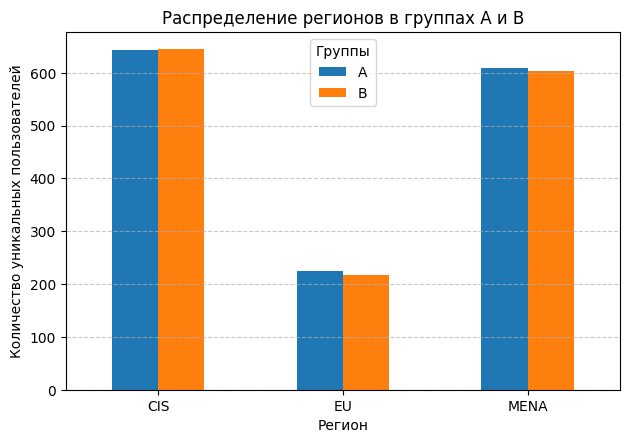

In [58]:
# Строим столбчатую диаграмму
plt.figure(figsize = (12, 6))
region_pivot.plot(kind = 'bar')

# Оформляем график
plt.title('Распределение регионов в группах A и B')
plt.legend(title = 'Группы')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Регион')
plt.tight_layout()
plt.xticks(rotation = 0)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.show()

#### 3.5. Вывод после проверки A/B-теста



На основе анализа первых дней данных A/B-теста были сделаны следующие **выводы**:

1. Количество пользователей в тестовой и контрольной группах отличается незначительно. Процентная разница составила около 0.74%, что укладывается в нормальные границы случайного распределения.

2. Пересечений пользователей между группами A и B не обнаружено. Это подтверждает, что выборки независимы, и пользователь попадает только в одну из групп, что соответствует требованиям проведения A/B-теста.

3. Сравнение долей типов устройств и регионов показало, что распределения между группами A и B практически идентичны. Это говорит о том, что группы хорошо сбалансированы и нет перекоса по устройствам или географическим признакам.

**Заключение:**
На данном этапе A/B-тест проходит корректно:

- случайное распределение пользователей между группами выполнено правильно,

- независимость выборок соблюдена,

- распределение по важным категориальным признакам (устройствам и регионам) сбалансировано.

Следовательно, можно переходить к дальнейшему анализу ключевых метрик и проверке статистической значимости результатов теста.



### 4. Проверка результатов A/B-теста



#### 4.1. Получение результатов теста и подсчёт основной метрики


In [23]:
# Загружаем данные
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
# Добавляем колонку good_session: 1 - если 4 и более страниц, иначе 0
sessions_test['good_session'] = (sessions_test['page_counter']>=4).astype(int)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста



Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Среднее количество уникальных сессий за день в группе А и B одинаково.

- Альтернативная гипотеза (Н1): Среднее количество уникальных сессий за день в группе А и B не равно.

In [24]:
import scipy.stats as st

# Рассчитываем кол-во уник. сессий для каждого дня каждой группы 
session_cnt_groupa = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date')['session_id'].nunique()
session_cnt_groupb = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date')['session_id'].nunique()
# Уровень значимости
alpha = 0.05

# Проводим двусторонний тест стьюдента с двумя выборками
results = st.ttest_ind(session_cnt_groupa,
                       session_cnt_groupb,
                       alternative = 'two-sided')
# Полученное p-value
p_value = results.pvalue
print(f"p-value={p_value}")
if p_value > alpha:
    print(f"Полученное значение {p_value=} больше критического уровня {alpha=}. Опровергнуть нулевую гипотезу нельзя")
else:
    print(f"Полученное значение {p_value=} меньше критического уровня {alpha=}. Принимаем альтернативную гипотезу.")

# Рассчитаем среднее кол-во сессий для каждой группы
mean_cnt_groupa = round(session_cnt_groupa.mean(), 2)
mean_cnt_groupb = round(session_cnt_groupb.mean(), 2)
print(f"Среднее количество уник. сессий в день группы А {mean_cnt_groupa}")
print(f"Среднее количество уник. сессий в день группы Б {mean_cnt_groupb}")

p-value=0.938219304859116
Полученное значение p_value=0.938219304859116 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя
Среднее количество уник. сессий в день группы А 2477.55
Среднее количество уник. сессий в день группы Б 2522.7


#### 4.3. Сравнение доли успешных сессий


In [25]:
# размеры выборок A и B
n_a, n_b = sessions_test[sessions_test.test_group=='A'].shape[0], sessions_test[sessions_test.test_group=='B'].shape[0] 

# количество успешных сессий в группе A и B
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0] 
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0] 

# рассчитываем доли успешных сессий для каждой группы: A и B
p_a, p_b = m_a/n_a, m_b/n_b 

# Разница между группами
difference = (p_b - p_a)*100

# Вывод результатов
print(f"Доля успешных сессий в группе A: {p_a:.4f}")
print(f"Доля успешных сессий в группе B: {p_b:.4f}")
print(f"Разница в долях успешных сессий (B - A) (в процентах): {difference:.2f}%")


Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница в долях успешных сессий (B - A) (в процентах): 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики


Сформулируем нулевую и альтернативную гипотезы:

Нулевая гипотеза (Н0): Доля успешных сессий в группах А и B одинакова.

Альтернативная гипотеза (Н1): Доля успешных сессий в группе А ниже, чем в группе B.

In [59]:
# Проверяем достаточно ли данных для проведения теста

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [60]:
from statsmodels.stats.proportion import proportions_ztest

# проводим Z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest( 
	[m_a, m_b],
	[n_a, n_b],
	alternative='smaller'
)
# Выводим полученное p-value
print(f'pvalue={p_value_ztest}') 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0001574739988036123
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента


**Выводы:**
- A/B-тест был проведён корректно. В исследовании приняли участие две равномерно распределённые группы пользователей — A (контрольная) и B (тестовая).
Общее количество задействованных пользователей и сессий было достаточным для оценки эффекта. Тест длился с 14 октября 2025 года по 2 ноября 2025 года.
- Внедрение нового алгоритма рекомендаций действительно оказало влияние на ключевую метрику. В группе B, где применялся новый алгоритм, доля успешных сессий (тех, где пользователь просмотрел 4 и более страниц) увеличилась примерно на 1.1% по сравнению с контрольной группой.
- Рассчитанное значение p-value составило 0.00016. Поскольку это значение меньше установленного уровня значимости 0.05, различие между группами можно считать статистически значимым.
- Положительное изменение ключевой метрики и статистическая значимость результата позволяют сделать вывод о том, что новый алгоритм рекомендаций действительно повышает вовлечённость пользователей и его стоит внедрить в приложение.